# TASK

### Deadline: 24 martie ora 23:59.
### Formular pentru trimiterea temei: https://forms.gle/LKCMJmyhS8Z8m7Rc9


1. Porniti de la un dataset artificial generat cu ajutorul metodei [`make_classification`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) din sklearn (minim 10000 de exemple, cu cel putin 100 de feature-uri relevante, grupate in cel putin 3 clase) sau puteti folosi un toy-dataset de [aici](https://scikit-learn.org/stable/datasets/toy_dataset.html).

2. Definiti un model cu cel putin 3 layere lineare, dintre care ultimul are dimensiunea outputului egala cu numarul de clase. Aplicati dupa fiecare layer linear (cu exceptia ultimului) o functie de activare aleasa de voi.

3. Impartiti datasetul in 80% train, 10% validare si 10% test. Creati cele trei dataloadere corespunzatoare fiecarui split.

4. Definiti functia de loss (cross-entropy) si un optimizer (SGD, Adam, etc.).

5. Antrenati modelul pentru mai multe epoci pe datele de train. La finalul fiecarei epoci evaluati performanta modelului pe datele de validare. Monitorizati la fiecare epoca eroarea medie si acuratetea pentru predictiile facute pe datele de train si separat pe datele de validare, pentru ca in cazul in care observati situatia de *overfit* sa puteti opri antrenarea.

6. Salvati modelul cu cea mai buna eroare de validare, calculata la finalul epocii respective.

7. Plotati pe acelasi grafic evolutia erorii de train si a erorii de validare la finalul fiecarei epoci. Plotati in alt grafic evolutia acuratetii pe datele de train si pe cele de validare.

8. Evaluati modelul (eroare, acuratete, macro-f1, etc.) pe datele de test.

9. Incercati sa adaugati dupa fiecare layer din model (cu exceptia ultimului) dropout cu un $p$ ales de voi. Analizati daca performanta unui model antrenat astfel este mai buna.


In [7]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import torch as torch
import numpy as np
from torch.utils.data import DataLoader
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

# 1
N_CLASSES = 5
N_FEATURES = 200
N_SAMPLES = 100000
BATCH_SIZE = 128
device = "cuda" if torch.cuda.is_available() else "cpu"

X, y = make_classification(n_samples=N_SAMPLES, n_classes=N_CLASSES, n_features=N_FEATURES, n_informative=150, random_state=42)
print(X[:10])
print(y[:10])


[[  0.32256635   9.56807414   5.5639312  ...  -5.25092757   3.3985659
   -2.47976429]
 [ -0.81052623  11.33103421 -16.37653105 ...   6.25319125   0.91365487
    2.69922974]
 [ -1.27729385  -3.13630879  -8.98495374 ...   8.60008904   3.98029703
   10.75129489]
 ...
 [ -1.01534994   2.6587725   -4.03618551 ...   9.89684477  -0.16574878
    3.81514782]
 [  0.85715604   2.05073202  -3.81690273 ...  -4.80180125   2.67341345
   -3.32629954]
 [  0.60445274   8.42594061   5.27353489 ... -12.95242205  -0.61731374
   -0.81125657]]
[4 2 4 3 1 1 3 4 4 1]


In [8]:
# 2
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = torch.nn.Linear(in_features=N_FEATURES, out_features=100)
        self.linear2 = torch.nn.Linear(in_features=100, out_features=40)
        self.linear3 = torch.nn.Linear(in_features=40, out_features=5)
        self.activation = torch.nn.ReLU()

    def forward(self, x):
        x = self.activation(self.linear1(x))
        x = self.activation(self.linear2(x))
        x = self.linear3(x)
        return x

# 9
class NetDropout(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.dropout = torch.nn.Dropout(p=0.2)
        self.linear1 = torch.nn.Linear(in_features=N_FEATURES, out_features=100)
        self.linear2 = torch.nn.Linear(in_features=100, out_features=40)
        self.linear3 = torch.nn.Linear(in_features=40, out_features=5)
        self.activation = torch.nn.ReLU()

    def forward(self, x):
        x = self.activation(self.linear1(x))
        x= self.dropout(x)
        x = self.activation(self.linear2(x))
        x= self.dropout(x)
        x = self.linear3(x)
        return x

model1 = Net()
model_dropout = NetDropout()
my_model = model_dropout
my_model.to(device)

NetDropout(
  (dropout): Dropout(p=0.2, inplace=False)
  (linear1): Linear(in_features=200, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=40, bias=True)
  (linear3): Linear(in_features=40, out_features=5, bias=True)
  (activation): ReLU()
)

In [9]:
# 3
class RandomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y)

    def __getitem__(self, item):
        return (
            self.X[item],
            self.y[item]
        )
    def __len__(self):
        return len(self.y)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

train_dataset = RandomDataset(X_train, y_train)
test_dataset = RandomDataset(X_test, y_test)
val_dataset = RandomDataset(X_val, y_val)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [10]:
# 4
loss_fn1 = torch.nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(my_model.parameters(), lr=0.01)

def test_fn(model: torch.nn.Module, loss_fn: torch.nn.Module, val_loader: DataLoader):
    model.eval()

    mean_loss = 0
    true_labels = []
    predicted_labels = []
    loss_data = []

    for data, labels in val_loader:
        data, labels = data.to(device), labels.to(device)

        output = model(data)
        loss = loss_fn(output, labels)

        mean_loss += loss.item()
        true_labels.extend(labels.tolist())
        predicted_labels.extend(output.max(1)[1].tolist())

    mean_loss /= len(test_dataloader)

    return mean_loss, true_labels, predicted_labels



def train_fn(epochs: int, train_loader: DataLoader, val_loader: DataLoader,
             model: torch.nn.Module, loss_fn: torch.nn.Module, optimizer: torch.optim):
    best_loss = None
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    for e in range(epochs):
        model.train()
        running_loss = 0
        true_labels_train = []
        predicted_labels_train = []

        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()

            output = model(data)
            loss = loss_fn(output, labels)
            loss.backward()
            running_loss += loss.item()
            optimizer.step()

            true_labels_train.extend(labels.tolist())
            predicted_labels_train.extend(output.argmax(1).tolist())


        mean_loss, true_labels, predicted_labels = test_fn(model, loss_fn, val_loader)
        accuracy = metrics.accuracy_score(true_labels, predicted_labels)

        print (f'Epoch: {e}')
        print (f'Mean loss: {mean_loss}')
        print (f'Accuracy:  {accuracy}', end='\n\n')

        ###################################### 6 #############################################
        if best_loss is None or mean_loss < best_loss:
            best_loss = mean_loss
            torch.save(model.state_dict(), "sol_model.pt")
        ###################################### 6 #############################################

        ###################################### 7 #############################################
        train_loss.append(running_loss / len(train_loader))
        val_loss.append(mean_loss)
        train_acc.append(metrics.accuracy_score(true_labels_train, predicted_labels_train))
        val_acc.append(accuracy)

    plt.figure(figsize=(13,5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label="train loss")
    plt.plot(val_loss, label="val loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label="train acc")
    plt.plot(val_acc, label="val acc")
    plt.legend()
    plt.show()
    ###################################### 7 #############################################







Epoch: 0
Mean loss: 0.36830621203289754
Accuracy:  0.8813333333333333

Epoch: 1
Mean loss: 0.29727910157245924
Accuracy:  0.9211111111111111

Epoch: 2
Mean loss: 0.2809056858473186
Accuracy:  0.9291111111111111

Epoch: 3
Mean loss: 0.21680799239798437
Accuracy:  0.946

Epoch: 4
Mean loss: 0.19952110219982605
Accuracy:  0.9517777777777777

Epoch: 5
Mean loss: 0.21605458997095686
Accuracy:  0.9478888888888889

Epoch: 6
Mean loss: 0.23805301664750786
Accuracy:  0.9447777777777778

Epoch: 7
Mean loss: 0.23895699115870875
Accuracy:  0.9488888888888889

Epoch: 8
Mean loss: 0.19056716698068607
Accuracy:  0.9598888888888889

Epoch: 9
Mean loss: 0.21854029954234255
Accuracy:  0.9551111111111111

Epoch: 10
Mean loss: 0.22400053137842613
Accuracy:  0.9466666666666667

Epoch: 11
Mean loss: 0.21089078372792353
Accuracy:  0.9471111111111111

Epoch: 12
Mean loss: 0.21732448116887973
Accuracy:  0.9515555555555556

Epoch: 13
Mean loss: 0.2434290374004388
Accuracy:  0.9428888888888889

Epoch: 14
Mean lo

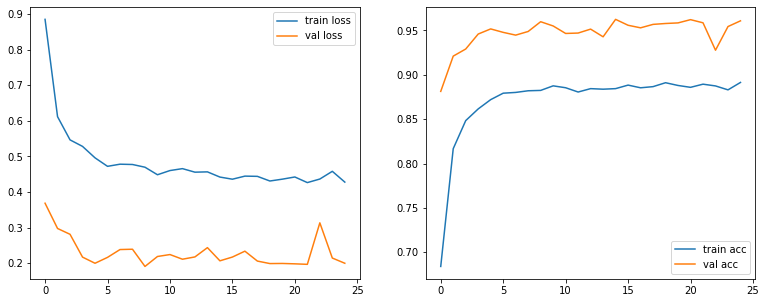

In [11]:
# 5
train_fn(25, train_dataloader, val_dataloader, my_model, loss_fn1, optimizer1)

Plots without dropout:
![plots_image](https://i.imgur.com/cMB6bXs.png)

We can see that the overfitting is now very heavily reduced.


In [12]:
# 8
test_mean_loss, test_true_labels, test_predicted_labels = test_fn(my_model, loss_fn1, test_dataloader)
test_acc = metrics.accuracy_score(test_true_labels, test_predicted_labels)
test_f1 = metrics.f1_score(test_true_labels, test_predicted_labels, average='macro')

print (f'Test mean loss: {test_mean_loss}')
print (f'Test accuracy:  {test_acc}')
print (f'Test f1-score:  {test_f1}')


Test mean loss: 0.2377704304136053
Test accuracy:  0.9594
Test f1-score:  0.959579082683223
